Social tagging of movies reveals a wide range of heterogeneous information about movies, like the genre, plot structure, soundtracks,
metadata, visual and emotional experiences. Such information can be valuable in building automatic systems to create tags for movies.
Automatic tagging systems can help recommendation engines to improve the retrieval of similar movies as well as help viewers to know
what to expect from a movie in advance. In this paper, we set out to the task of collecting a corpus of movie plot synopses and tags. We
describe a methodology that enabled us to build a fine-grained set of around 70 tags exposing heterogeneous characteristics of movie
plots and the multi-label associations of these tags with some 14K movie plot synopses. We investigate how these tags correlate with
movies and the flow of emotions throughout different types of movies. Finally, we use this corpus to explore the feasibility of inferring
tags from plot synopses. We expect the corpus will be useful in other tasks where analysis of narratives is relevant.


# https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags
# https://arxiv.org/pdf/1802.07858.pdf
    


# Real World / Business Objectives and Constraints 

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience.
3. No strict latency constraints.

# Performance Metrics

In [4]:
import spacy
import pandas as pd
import numpy as np
import nltk
import re
from contractions import CONTRACTION_MAP
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import unicodedata
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
import time
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
import gensim
import tqdm

In [5]:
data = pd.read_csv('mpst_full_data.csv',encoding='utf-8' )

In [23]:
# https://github.com/nkartik94/Multi-Label-Text-Classification/blob/master/Mark_6.ipynb
# https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72
# Removing HTML tags

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext


# Stemming

stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

# Lemmatization

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


# stopwords
nlp = spacy.load('en', parse=True, tag=True, entity=True)
stopword_list = set(nltk.corpus.stopwords.words('english'))
stopword_list.remove('no')
stopword_list.remove('not')
re_stop_words = re.compile(r"\b(" + "|".join(stopword_list) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)


# CLean punctuation

def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def stemming_tag(sentence):
    stemSentence = ""
    count = 0
    for word in sentence.split(","):
        stem = stemmer.stem(word)
        stemSentence += stem.strip()
        if count < len(sentence.split(","))-1:
            stemSentence += ","
        else:
            stemSentence += ""
        count += 1
    stemSentence = stemSentence.strip()
    return stemSentence

In [7]:
data['plot_synopsis'] = data['plot_synopsis'].apply(cleanHtml) \
                                            .apply(stemming) \
                                            .apply(lemmatize_text) \
                                            .apply(cleanPunc)
data['tags'] = data['tags'].apply(stemming_tag)

# Analysis of Tags

## Number of times a tag appeared

In [8]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","))
tag_dtm = vectorizer.fit_transform(data['tags'])

In [9]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 14828
Number of unique tags : 71


In [10]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['absurd', 'action', 'adult comedi', 'allegori', 'alternate histori', 'alternate r', 'anti war', 'atmospher', 'autobiograph', 'avant gard']


In [11]:
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [12]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,absurd,270
1,action,664
2,adult comedi,128
3,allegori,139
4,alternate histori,102


In [13]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

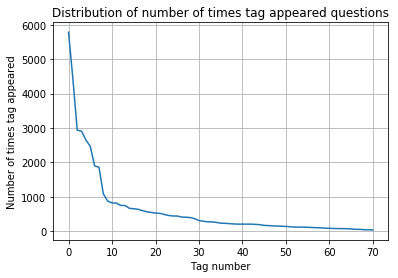

In [14]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

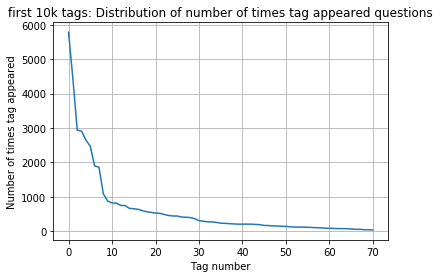

3 [5782  441  139]


In [17]:
plt.plot(tag_counts[0:1000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:25]), tag_counts[0:1000:25])

# Tags Per Movie

In [19]:
#Storing the count of tag in each question in list 'tag_count'
tag_mov_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_mov_count=[int(j) for i in tag_mov_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_mov_count)))

print(tag_mov_count[:5])

We have total 14828 datapoints.
[5, 1, 1, 4, 10]


In [23]:
print( "Maximum number of tags per movie: %d"%max(tag_mov_count))
print( "Minimum number of tags per movie: %d"%min(tag_mov_count))
print( "Avg. number of tags per movie: %f"% ((sum(tag_mov_count)*1.0)/len(tag_mov_count)))

Maximum number of tags per movie: 25
Minimum number of tags per movie: 1
Avg. number of tags per movie: 2.981252


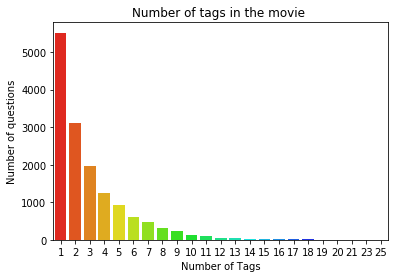

In [22]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the movie ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

# Most Frequent Tags

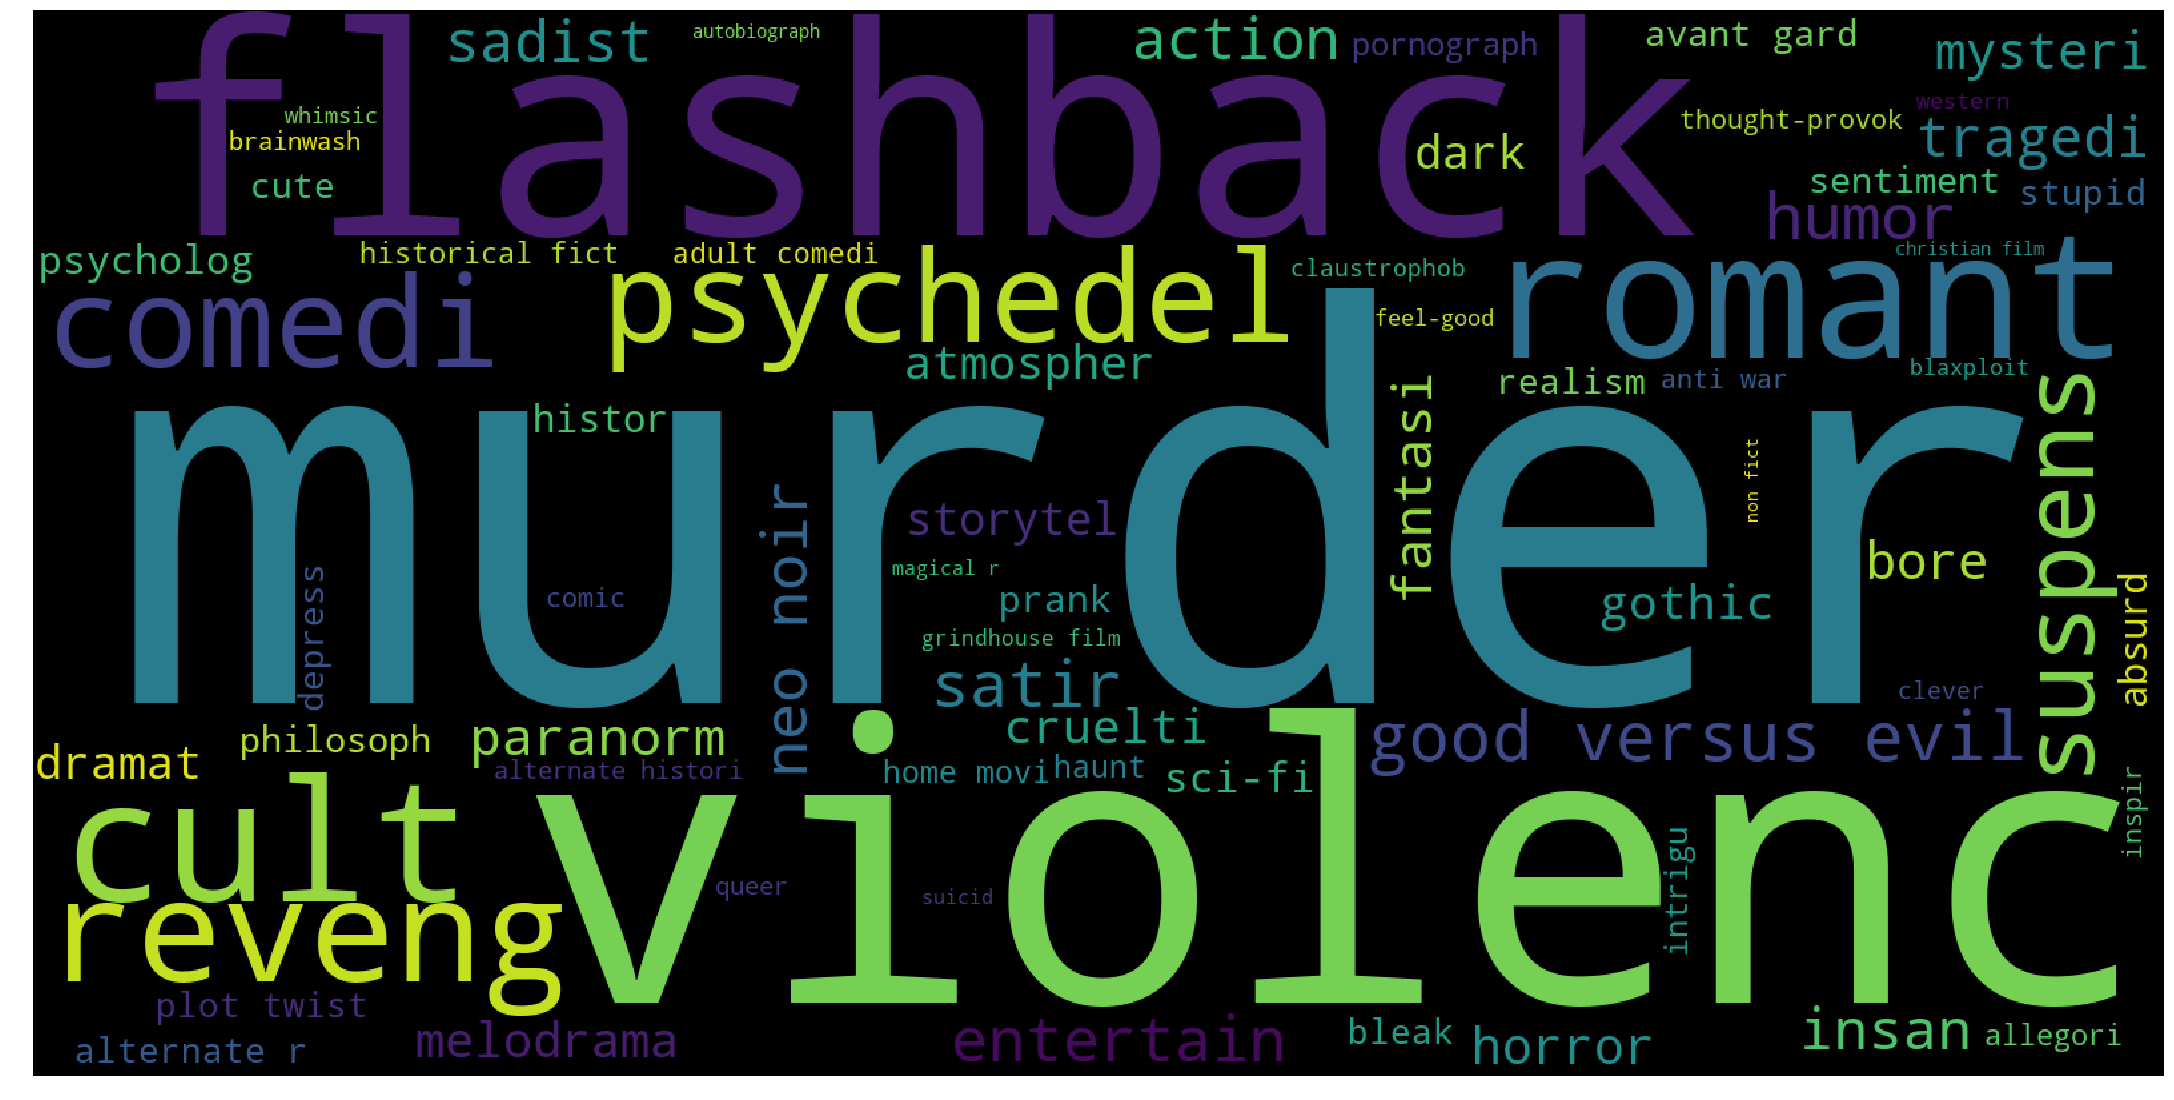

Time taken to run this cell : 0:00:17.509760


In [24]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

## The top 20 tags

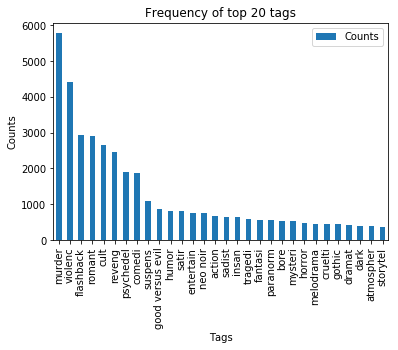

In [25]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [5]:
data['plot_synopsis'].head()

0    note : this synopsi be for the orgin italian r...
1    two thousand year ago   nhagruul the foul   a ...
2    matuschek s   a gift store in budapest   be th...
3    glenn holland   not a morn person by anyon sta...
4    in may 1980   a cuban man name toni montana   ...
Name: plot_synopsis, dtype: object

In [26]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def execute_query(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        execute_query(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS MovieDetailsProcessed1 (imdb_id text NOT NULL, title text, plot_synopsis text, tags text, split text, synopsis_source text);"""
create_database_table("Processed1.db", sql_create_table)

Tables in the databse:
MovieDetailsProcessed1


In [27]:
#Creating a new database with no duplicates
if os.path.isfile('Processed1.db'):
    disk_dup = create_engine("sqlite:///Processed1.db")
    no_dup = pd.DataFrame(data)
    no_dup.to_sql('MovieDetailsProcessed1',disk_dup, if_exists='replace')

In [28]:
#Learn SQl: https://www.w3schools.com/sql/default.asp
if os.path.isfile('Processed1.db'):
    start = datetime.now()
    con = sqlite3.connect('Processed1.db')
    df_no_dup = pd.read_sql_query('SELECT * FROM MovieDetailsProcessed1', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:00.428851


In [29]:
sql_create_table = """CREATE TABLE IF NOT EXISTS MovieDetailsProcessedFinal1 (moviedetails text NOT NULL, tags text, words_pre integer, words_post integer,split text, synopsis_source text);"""
create_database_table("Processed_Final1.db", sql_create_table)

Tables in the databse:
MovieDetailsProcessedFinal1


In [30]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'Processed1.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, plot_synopsis, Tags, split,synopsis_source  From MovieDetailsProcessed1 ORDER BY RANDOM();")

In [31]:
write_db = 'Processed_Final1.db'
conn_w = create_connection(write_db)
writer = conn_w.cursor()
writer.execute("DELETE FROM MovieDetailsProcessedFinal1 WHERE 1")
for row in reader:

    title, moviedetails, tags = row[0], row[1], row[2]
    x = len(moviedetails)+len(title)
    title=title.encode('utf-8')
    moviedetails=str(title)+" "+str(moviedetails)
    moviedetails=re.sub(r'[^A-Za-z]+',' ',moviedetails)
    words=word_tokenize(str(moviedetails.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    moviedetails=' '.join(str(stemmer.stem(j)) for j in words if j not in stopword_list and (len(j)!=1))
    tup = (moviedetails,tags,x,len(moviedetails),row[3],row[4])
    #print(moviedetails + "---" + tags + "---" + str(x)+"---"+str(len(moviedetails)))
   
    writer.execute("insert into MovieDetailsProcessedFinal1(moviedetails,tags,words_pre,words_post, split,synopsis_source) values (?,?,?,?,?,?)",tup)

In [32]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [5]:
#Learn SQl: https://www.w3schools.com/sql/default.asp
if os.path.isfile('Processed_Final1.db'):
    start = datetime.now()
    con = sqlite3.connect('Processed_Final1.db')
    df_train = pd.read_sql_query('SELECT * FROM MovieDetailsProcessedFinal1 where split="train"', con)
    df_test = pd.read_sql_query('SELECT * FROM MovieDetailsProcessedFinal1 where split="test"', con)
    df_val = pd.read_sql_query('SELECT * FROM MovieDetailsProcessedFinal1 where split="val"', con)
    
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:02.145909


In [6]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary='true')
multilabel_y_train = vectorizer.fit_transform(df_train['tags'])
multilabel_y_test = vectorizer.transform(df_test['tags'])
multilabel_y_val = vectorizer.transform(df_val['tags'])

# unigram

In [50]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=2, max_features=5000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,1))
df_train_uni = vectorizer.fit_transform(df_train['moviedetails'])
df_test_uni = vectorizer.transform(df_test['moviedetails'])
df_val_uni = vectorizer.transform(df_val['moviedetails'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:05.942170


In [51]:
df_train_uni_final = np.concatenate([df_train[['words_pre','words_post']],df_train_uni.toarray()], axis=1)
df_test_uni_final = np.concatenate([df_test[['words_pre','words_post']],df_test_uni.toarray()], axis=1)
df_val_uni_final = np.concatenate([df_val[['words_pre','words_post']],df_val_uni.toarray()], axis=1)

In [52]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(df_train_uni_final)
# transform both train and test data
final_tf_idf_train_uni = scaler.transform(df_train_uni_final)
final_tf_idf_test_uni = scaler.transform(df_test_uni_final)
final_tf_idf_val_uni = scaler.transform(df_val_uni_final)

In [53]:
def classifierdetl(scorelist,x_data_train, y_data_train):
    best_alpha = np.argmax(scorelist)
    clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=alpha[best_alpha], penalty='l1', random_state=42), n_jobs=-1)
    clf.fit(x_data_train, y_data_train)
    return clf

     
def score_report(func,scorelist,x_data_train, y_data_train,x_data_test,y_data_test):   
    predictions = func(scorelist,x_data_train, y_data_train).predict(x_data_test)
    print("accuracy :",metrics.accuracy_score(y_data_test,predictions))
    print("macro f1 score :",metrics.f1_score(y_data_test, predictions, average = 'macro'))
    print("micro f1 scoore :",metrics.f1_score(y_data_test, predictions, average = 'micro'))
    print("hamming loss :",metrics.hamming_loss(y_data_test,predictions))

In [54]:
alpha = [10 ** x for x in range(-6, -3)]
micro_f1_score = []
for i in alpha:
    print("for alpha =", i)
    clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1', random_state=42), n_jobs=-1)    
    clf.fit(final_tf_idf_train_uni, multilabel_y_train)
    predictions = clf.predict(final_tf_idf_val_uni)
    micro_f1_score.append(metrics.f1_score(multilabel_y_val, predictions, average = 'micro'))
    print("micro f1 score:" + str(metrics.f1_score(multilabel_y_val, predictions, average = 'micro')))

print("Train Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,final_tf_idf_train_uni, multilabel_y_train,final_tf_idf_train_uni, multilabel_y_train)
print("Test Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,final_tf_idf_train_uni, multilabel_y_train,final_tf_idf_test_uni, multilabel_y_test)
print("Validation Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,final_tf_idf_train_uni, multilabel_y_train,final_tf_idf_val_uni, multilabel_y_val)

for alpha = 1e-06
micro f1 score:0.28254847645429365
for alpha = 1e-05
micro f1 score:0.28128675198893116
for alpha = 0.0001
micro f1 score:0.26750700280112044
Train Score details
accuracy : 0.638318052481821
macro f1 score : 0.9465066963827777
micro f1 scoore : 0.9074617369481461
hamming loss : 0.007771786160105326
Test Score details
accuracy : 0.030681051921780174
macro f1 score : 0.11131047794300596
micro f1 scoore : 0.27885472370766484
hamming loss : 0.06147607153372019
Validation Score details
accuracy : 0.023177412557943533
macro f1 score : 0.11632929520148917
micro f1 scoore : 0.28254847645429365
hamming loss : 0.06148988325231626


# Bigram

In [55]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=2, max_features=5000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(2,2))
df_train_bi = vectorizer.fit_transform(df_train['moviedetails'])
df_test_bi = vectorizer.transform(df_test['moviedetails'])
df_val_bi = vectorizer.transform(df_val['moviedetails'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:25.574585


In [56]:
df_train_bi_final = np.concatenate([df_train[['words_pre','words_post']],df_train_bi.toarray()], axis=1)
df_test_bi_final = np.concatenate([df_test[['words_pre','words_post']],df_test_bi.toarray()], axis=1)
df_val_bi_final = np.concatenate([df_val[['words_pre','words_post']],df_val_bi.toarray()], axis=1)

In [57]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(df_train_bi_final)
# transform both train and test data
final_tf_idf_train_bi = scaler.transform(df_train_bi_final)
final_tf_idf_test_bi = scaler.transform(df_test_bi_final)
final_tf_idf_val_bi = scaler.transform(df_val_bi_final)

In [58]:
alpha = [10 ** x for x in range(-6, -3)]
micro_f1_score = []
for i in alpha:
    print("for alpha =", i)
    clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1', random_state=42), n_jobs=-1)    
    clf.fit(final_tf_idf_train_bi, multilabel_y_train)
    predictions = clf.predict(final_tf_idf_val_bi)
    micro_f1_score.append(metrics.f1_score(multilabel_y_val, predictions, average = 'micro'))
    print("micro f1 score:" + str(metrics.f1_score(multilabel_y_val, predictions, average = 'micro')))

print("Train Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,final_tf_idf_train_bi, multilabel_y_train,final_tf_idf_train_bi, multilabel_y_train)
print("Test Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,final_tf_idf_train_bi, multilabel_y_train,final_tf_idf_test_bi, multilabel_y_test)
print("Validation Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,final_tf_idf_train_bi, multilabel_y_train,final_tf_idf_val_bi, multilabel_y_val)

for alpha = 1e-06
micro f1 score:0.23391588246591127
for alpha = 1e-05
micro f1 score:0.2327823691460055
for alpha = 0.0001
micro f1 score:0.22083141938447404
Train Score details
accuracy : 0.624934134260723
macro f1 score : 0.9462973011511822
micro f1 scoore : 0.903910275841164
hamming loss : 0.007998883807640871
Test Score details
accuracy : 0.020229265003371546
macro f1 score : 0.07702479101153975
micro f1 scoore : 0.2286308131982333
hamming loss : 0.0704937650176175
Validation Score details
accuracy : 0.01980615254951538
macro f1 score : 0.07898572060037966
micro f1 scoore : 0.23391588246591127
hamming loss : 0.07102793753672478


# Trigram

In [59]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=2, max_features=5000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(3,3))
df_train_tri = vectorizer.fit_transform(df_train['moviedetails'])
df_test_tri = vectorizer.transform(df_test['moviedetails'])
df_val_tri = vectorizer.transform(df_val['moviedetails'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:33.492401


In [60]:
df_train_tri_final = np.concatenate([df_train[['words_pre','words_post']],df_train_tri.toarray()], axis=1)
df_test_tri_final = np.concatenate([df_test[['words_pre','words_post']],df_test_tri.toarray()], axis=1)
df_val_tri_final = np.concatenate([df_val[['words_pre','words_post']],df_val_tri.toarray()], axis=1)

In [61]:
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(df_train_tri_final)
# transform both train and test data
final_tf_idf_train_tri = scaler.transform(df_train_tri_final)
final_tf_idf_test_tri = scaler.transform(df_test_tri_final)
final_tf_idf_val_tri = scaler.transform(df_val_tri_final)

In [62]:
alpha = [10 ** x for x in range(-6, -3)]
micro_f1_score = []
for i in alpha:
    print("for alpha =", i)
    clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1', random_state=42), n_jobs=-1)    
    clf.fit(final_tf_idf_train_tri, multilabel_y_train)
    predictions = clf.predict(final_tf_idf_val_tri)
    micro_f1_score.append(metrics.f1_score(multilabel_y_val, predictions, average = 'micro'))
    print("micro f1 score:" + str(metrics.f1_score(multilabel_y_val, predictions, average = 'micro')))

print("Train Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,final_tf_idf_train_tri, multilabel_y_train,final_tf_idf_train_tri, multilabel_y_train)
print("Test Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,final_tf_idf_train_tri, multilabel_y_train,final_tf_idf_test_tri, multilabel_y_test)
print("Validation Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,final_tf_idf_train_tri, multilabel_y_train,final_tf_idf_val_tri, multilabel_y_val)

for alpha = 1e-06
micro f1 score:0.18854285886392383
for alpha = 1e-05
micro f1 score:0.18930741190765493
for alpha = 0.0001
micro f1 score:0.18712310409940916
Train Score details
accuracy : 0.2688376014332385
macro f1 score : 0.7014537603463928
micro f1 scoore : 0.6983494910775758
hamming loss : 0.024061960550318458
Test Score details
accuracy : 0.01078894133513149
macro f1 score : 0.06349342959848796
micro f1 scoore : 0.18037387623079482
hamming loss : 0.08182405288100823
Validation Score details
accuracy : 0.01390644753476612
macro f1 score : 0.07483384529637065
micro f1 scoore : 0.18930741190765493
hamming loss : 0.07920086893039655


# unigram + Bigram + Trigram

In [66]:
final_tf_idf_train_ubt = np.concatenate([final_tf_idf_train_uni,final_tf_idf_train_bi[:,2:],final_tf_idf_train_tri[:,2:]], axis=1)
final_tf_idf_test_ubt = np.concatenate([final_tf_idf_test_uni,final_tf_idf_test_bi[:,2:],final_tf_idf_test_tri[:,2:]], axis=1)
final_tf_idf_val_ubt = np.concatenate([final_tf_idf_val_uni,final_tf_idf_val_bi[:,2:],final_tf_idf_val_tri[:,2:]], axis=1)

In [67]:
alpha = [10 ** x for x in range(-6, -3)]
micro_f1_score = []
for i in alpha:
    print("for alpha =", i)
    clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1', random_state=42), n_jobs=-1)    
    clf.fit(final_tf_idf_train_ubt, multilabel_y_train)
    predictions = clf.predict(final_tf_idf_val_ubt)
    micro_f1_score.append(metrics.f1_score(multilabel_y_val, predictions, average = 'micro'))
    print("micro f1 score:" + str(metrics.f1_score(multilabel_y_val, predictions, average = 'micro')))

print("Train Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,final_tf_idf_train_ubt, multilabel_y_train,final_tf_idf_train_ubt, multilabel_y_train)
print("Test Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,final_tf_idf_train_ubt, multilabel_y_train,final_tf_idf_test_ubt, multilabel_y_test)
print("Validation Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,final_tf_idf_train_ubt, multilabel_y_train,final_tf_idf_val_ubt, multilabel_y_val)

for alpha = 1e-06
micro f1 score:0.27374031007751937
for alpha = 1e-05
micro f1 score:0.27428928459856294
for alpha = 0.0001
micro f1 score:0.27110389610389607
Train Score details
accuracy : 0.9363473495626515
macro f1 score : 0.9728223629700204
micro f1 scoore : 0.9731908745518434
hamming loss : 0.0022309004199080034
Test Score details
accuracy : 0.03573836817262306
macro f1 score : 0.09599373612845243
micro f1 scoore : 0.27171270029303574
hamming loss : 0.055469024531545306
Validation Score details
accuracy : 0.03076274757690687
macro f1 score : 0.09746324566084068
micro f1 scoore : 0.27428928459856294
hamming loss : 0.055150964785764735


# Char n-gram

In [68]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(3, 3),
    max_features=10000)
df_train_multilabel_char = char_vectorizer.fit_transform(df_train['moviedetails'])
df_test_multilabel_char = char_vectorizer.transform(df_test['moviedetails'])
df_val_multilabel_char = char_vectorizer.transform(df_val['moviedetails'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 1:06:17.594724


In [69]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(4, 4),
    max_features=10000)
df_train_multilabel_char4 = char_vectorizer.fit_transform(df_train['moviedetails'])
df_test_multilabel_char4 = char_vectorizer.transform(df_test['moviedetails'])
df_val_multilabel_char4 = char_vectorizer.transform(df_val['moviedetails'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 1:07:11.151455


In [70]:
df_train_final_char = np.concatenate((df_train_multilabel_char.toarray(), df_train_multilabel_char4.toarray()), axis=1)
df_test_final_char = np.concatenate((df_test_multilabel_char.toarray(), df_test_multilabel_char4.toarray()), axis=1)
df_val_final_char = np.concatenate((df_val_multilabel_char.toarray(), df_val_multilabel_char4.toarray()), axis=1)

In [71]:
alpha = [10 ** x for x in range(-6, -4)]
micro_f1_score = []
for i in alpha:
    print("for alpha =", i)
    clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1', random_state=42), n_jobs=-1)    
    clf.fit(df_train_final_char, multilabel_y_train)
    predictions = clf.predict(df_val_final_char)
    micro_f1_score.append(metrics.f1_score(multilabel_y_val, predictions, average = 'micro'))
    print("micro f1 score:" + str(metrics.f1_score(multilabel_y_val, predictions, average = 'micro')))

print("Train Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,df_train_final_char, multilabel_y_train,df_train_final_char, multilabel_y_train)
print("Test Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,df_train_final_char, multilabel_y_train,df_test_final_char, multilabel_y_test)
print("Validation Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,df_train_final_char, multilabel_y_train,df_val_final_char, multilabel_y_val)

for alpha = 1e-06
micro f1 score:0.2934156722022866
for alpha = 1e-05
micro f1 score:0.3308499830680664
Train Score details
accuracy : 0.6175571714616925
macro f1 score : 0.7208227021544005
micro f1 scoore : 0.8934313707053801
hamming loss : 0.008411518748914607
Test Score details
accuracy : 0.05428186109238031
macro f1 score : 0.10802564298268309
micro f1 scoore : 0.32436153369587667
hamming loss : 0.04660803662161777
Validation Score details
accuracy : 0.05351875263379688
macro f1 score : 0.11448774793386743
micro f1 scoore : 0.3308499830680664
hamming loss : 0.046912744906014256


# tf-idf weighted Word Embedding 

In [20]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [21]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=2, max_features=10000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
df_train_multilabel = vectorizer.fit_transform(df_train['moviedetails'])
df_test_multilabel = vectorizer.transform(df_test['moviedetails'])
df_val_multilabel = vectorizer.transform(df_val['moviedetails'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:38.018785


In [24]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent_train=[]
for sent in df_train['moviedetails'].values:
    filtered_sentence=[]
    sent=cleanHtml(sent)
    for w in sent.split():
        for cleaned_words in cleanPunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [25]:
# Train your own Word2Vec model using your own text corpus
import gensim
list_of_sent_test=[]
for sent in df_test['moviedetails'].values:
    filtered_sentence=[]
    sent=cleanHtml(sent)
    for w in sent.split():
        for cleaned_words in cleanPunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [26]:
# Train your own Word2Vec model using your own text corpus
import gensim
list_of_sent_val=[]
for sent in df_val['moviedetails'].values:
    filtered_sentence=[]
    sent=cleanHtml(sent)
    for w in sent.split():
        for cleaned_words in cleanPunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_val.append(filtered_sentence)

In [32]:
# TF-IDF weighted Word2Vec
tfidf_feat = vectorizer.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
pbar = tqdm.tqdm(total=100)
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(96) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = nlp(word).vector
                                     #obtain the tf_idfidf of a word in a sentence/review
            tf_idf = df_train_multilabel[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    pbar.update(10)
pbar.close()

94890it [20:22:58,  2.39it/s]                                                     


In [34]:
import pickle
file = open('tfidf_sent_vectors_train.pkl', 'wb')
pickle.dump(tfidf_sent_vectors_train, file)
file.close()

In [35]:
import pickle
file = open('tfidf_sent_vectors_train.pkl', 'rb')
tfidf_sent_vectors_train = pickle.load(file)
file.close()

In [97]:
# TF-IDF weighted Word2Vec
# tfidf_feat = vectorizer.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(96) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
       try:                                #obtain the tf_idfidf of a word in a sentence/review
            vec = nlp(word).vector
                                     #obtain the tf_idfidf of a word in a sentence/review
            tf_idf = df_test_multilabel[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
       except:
            pass
       
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [36]:
file = open('tfidf_sent_vectors_test.pkl', 'rb')
tfidf_sent_vectors_test = pickle.load(file)
file.close()

In [ ]:
# TF-IDF weighted Word2Vec
# tfidf_feat = vectorizer.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_val = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_val: # for each review/sentence
    sent_vec = np.zeros(96) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        
        try:                                #obtain the tf_idfidf of a word in a sentence/review
            vec = nlp(word).vector    #obtain the tf_idfidf of a word in a sentence/review
            tf_idf = df_val_multilabel[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf       
        except:
            pass
        
    sent_vec /= weight_sum
    tfidf_sent_vectors_val.append(sent_vec)
    row += 1

In [37]:
file = open('tfidf_sent_vectors_val.pkl', 'rb')
tfidf_sent_vectors_val = pickle.load(file)
file.close()

In [38]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(tfidf_sent_vectors_train)
# transform both train and test data
tfidf_sent_vectors_train = scaler.transform(tfidf_sent_vectors_train)
tfidf_sent_vectors_test = scaler.transform(tfidf_sent_vectors_test)
tfidf_sent_vectors_val = scaler.transform(tfidf_sent_vectors_val)

In [39]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary='true')
multilabel_y_train = vectorizer.fit_transform(df_train['tags'])
multilabel_y_test = vectorizer.transform(df_test['tags'])
multilabel_y_val = vectorizer.transform(df_val['tags'])

In [40]:
alpha = [10 ** x for x in range(-6, 3)]
micro_f1_score = []
for i in alpha:
    print("for alpha =", i)
    clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1', random_state=42), n_jobs=-1)    
    clf.fit(tfidf_sent_vectors_train, multilabel_y_train)
    predictions = clf.predict(tfidf_sent_vectors_val)
    micro_f1_score.append(metrics.f1_score(multilabel_y_val, predictions, average = 'micro'))
    print("micro f1 score:" + str(metrics.f1_score(multilabel_y_val, predictions, average = 'micro')))

print("Train Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,tfidf_sent_vectors_train, multilabel_y_train,tfidf_sent_vectors_train, multilabel_y_train)
print("Test Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,tfidf_sent_vectors_train, multilabel_y_train,tfidf_sent_vectors_test, multilabel_y_test)
print("Validation Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,tfidf_sent_vectors_train, multilabel_y_train,tfidf_sent_vectors_val, multilabel_y_val)

for alpha = 1e-06
micro f1 score:0.10781396139784032
for alpha = 1e-05
micro f1 score:0.14809720311783584
for alpha = 0.0001
micro f1 score:0.10845139228138738
for alpha = 0.001
micro f1 score:0.06728620162333843
for alpha = 0.01
micro f1 score:0.0
for alpha = 0.1
micro f1 score:0.0
for alpha = 1
micro f1 score:0.0
for alpha = 10
micro f1 score:0.0
for alpha = 100
micro f1 score:0.10319874147876247
Train Score details
accuracy : 0.006639266519127411
macro f1 score : 0.053624166363810497
micro f1 scoore : 0.15984465422106012
hamming loss : 0.06486235359252152
Test Score details
accuracy : 0.006743088334457181
macro f1 score : 0.029000567086222184
micro f1 scoore : 0.14578807627323195
hamming loss : 0.06722194257927877
Validation Score details
accuracy : 0.008006742520016857
macro f1 score : 0.03206230507521615
micro f1 scoore : 0.14809720311783584
hamming loss : 0.06616691298231869


# POS tagging

In [41]:
dict1 = {}
for i in df_train['moviedetails'].values:
    tokens = nltk.word_tokenize(i)
    tags = nltk.pos_tag(tokens)
    for j in tags:
        if j not in dict1:
            dict1[j[0]] = j[1]
        else:
            pass

In [42]:
train_sent = []
for i in df_train['moviedetails'].values:
    temp = ""
    tokens = nltk.word_tokenize(i)
    for word in tokens:
        temp += dict1.get(word)
        temp += " "
    train_sent.append(temp)

In [43]:
train_data_pos = pd.DataFrame(train_sent)

In [44]:
test_sent = []
for i in df_test['moviedetails'].values:
    temp = ""
    tokens = nltk.word_tokenize(i)
    for word in tokens:
        if dict1.get(word) is not None:
            temp += dict1.get(word)
            temp += " "
        else:
            temp += ""
    test_sent.append(temp)

In [45]:
test_data_pos = pd.DataFrame(test_sent)

In [46]:
val_sent = []
for i in df_val['moviedetails'].values:
    temp = ""
    tokens = nltk.word_tokenize(i)
    for word in tokens:
        if dict1.get(word) is not None:
            temp += dict1.get(word)
            temp += " "
        else:
            temp += ""
    val_sent.append(temp)

In [47]:
val_data_pos = pd.DataFrame(val_sent)

In [48]:
vectorizer = CountVectorizer(ngram_range=(1,3))
train_pos = vectorizer.fit_transform(train_sent)
test_pos = vectorizer.transform(test_sent)
val_pos = vectorizer.transform(val_sent)

In [49]:
alpha = [10 ** x for x in range(-6, 3)]
micro_f1_score = []
for i in alpha:
    print("for alpha =", i)
    clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1', random_state=42))    
    clf.fit(train_pos, multilabel_y_train)
    predictions = clf.predict(test_pos)
    micro_f1_score.append(metrics.f1_score(multilabel_y_test, predictions, average = 'micro'))
    print("micro f1 score:" + str(metrics.f1_score(multilabel_y_test, predictions, average = 'micro')))

print("Train Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,train_pos, multilabel_y_train,train_pos, multilabel_y_train)
print("Test Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,train_pos, multilabel_y_train,test_pos, multilabel_y_test)
print("Validation Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,train_pos, multilabel_y_train,val_pos, multilabel_y_val)

for alpha = 1e-06
micro f1 score:0.10408737382094986
for alpha = 1e-05
micro f1 score:0.14747105423522242
for alpha = 0.0001
micro f1 score:0.18039327443716158
for alpha = 0.001
micro f1 score:0.17277852348993286
for alpha = 0.01
micro f1 score:0.16610636538991458
for alpha = 0.1
micro f1 score:0.1868974042027194
for alpha = 1
micro f1 score:0.0033246753246753244
for alpha = 10
micro f1 score:0.0
for alpha = 100
micro f1 score:0.09943276609943276
Train Score details
accuracy : 0.01032774791864264
macro f1 score : 0.028598348075664814
micro f1 scoore : 0.18185053380782917
hamming loss : 0.06142323431579041
Test Score details
accuracy : 0.009777478084962913
macro f1 score : 0.029793134521289
micro f1 scoore : 0.1868974042027194
hamming loss : 0.06247328882261879
Validation Score details
accuracy : 0.016013485040033713
macro f1 score : 0.029317903390571172
micro f1 scoore : 0.18540340953727708
hamming loss : 0.06154330110456248


## LDA topic modeling with top 20 words for each review

In [11]:
# https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28

In [7]:
movdetail = []
for i in df_train['moviedetails']:
    movdetail1 = []
    for j in i.split():
        movdetail1.append(j)
    movdetail.append(movdetail1)

In [8]:
'''
Create a dictionary from 'processed_docs' containing the number of times a word appears 
in the training set using gensim.corpora.Dictionary and call it 'dictionary'
'''
dictionary = gensim.corpora.Dictionary(movdetail)

In [9]:
'''
Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'
'''
bow_corpus = [dictionary.doc2bow(doc) for doc in movdetail]

In [10]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 72, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

In [ ]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

In [12]:
train_vecs = []
for i in range(multilabel_y_train.shape[0]):
    top_topics = lda_model.get_document_topics(bow_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    topic_vec.extend([len(bow_corpus[i])]) # length review
    train_vecs.append(topic_vec)

In [14]:
test_vecs = []
for i in range(multilabel_y_test.shape[0]):
    top_topics = lda_model.get_document_topics(bow_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    topic_vec.extend([len(bow_corpus[i])]) # length review
    test_vecs.append(topic_vec)

In [15]:
val_vecs = []
for i in range(multilabel_y_val.shape[0]):
    top_topics = lda_model.get_document_topics(bow_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    topic_vec.extend([len(bow_corpus[i])]) # length review
    val_vecs.append(topic_vec)

In [19]:
alpha = [10 ** x for x in range(-6, -3)]
micro_f1_score = []
for i in alpha:
    print("for alpha =", i)
    clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1', random_state=42), n_jobs=-1)    
    clf.fit(train_vecs, multilabel_y_train)
    predictions = clf.predict(test_vecs)
    micro_f1_score.append(f1_score(multilabel_y_test, predictions, average = 'micro'))
    print("micro f1 score:" + str(f1_score(multilabel_y_test, predictions, average = 'micro')))

print("Train Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,train_vecs, multilabel_y_train,train_vecs, multilabel_y_train)
print("Test Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,train_vecs, multilabel_y_train,test_vecs, multilabel_y_test)
print("Validation Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,train_vecs, multilabel_y_train,val_vecs, multilabel_y_val)

for alpha = 1e-06
micro f1 score:0.09696402300387856
for alpha = 1e-05
micro f1 score:0.02152152152152152
for alpha = 0.0001
micro f1 score:0.09385360877327212
Train Score details
accuracy : 0.0008430814627463379
macro f1 score : 0.0055405132025814164
micro f1 scoore : 0.09272340425531914
hamming loss : 0.06329345023667138
Test Score details
accuracy : 0.0
macro f1 score : 0.005887376298767205
micro f1 scoore : 0.09696402300387856
hamming loss : 0.06412582032993647
Validation Score details
accuracy : 0.00042140750105351877
macro f1 score : 0.0058336226013982
micro f1 scoore : 0.09724554921061472
hamming loss : 0.06380465684965249


# Combining All features:

In [75]:
train_data = np.concatenate((final_tf_idf_train_ubt,df_train_final_char,tfidf_sent_vectors_train,train_pos.toarray()), axis=1)
test_data = np.concatenate((final_tf_idf_test_ubt,df_test_final_char,tfidf_sent_vectors_test,test_pos.toarray()), axis=1)
val_data = np.concatenate((final_tf_idf_val_ubt,df_val_final_char,tfidf_sent_vectors_val,val_pos.toarray()), axis=1)

# SGD with log loss

In [76]:
alpha = [10 ** x for x in range(-6, 3)]
micro_f1_score = []
for i in alpha:
    print("for alpha =", i)
    clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=i, penalty='l1', random_state=42), n_jobs=-1)    
    clf.fit(train_data, multilabel_y_train)
    predictions = clf.predict(val_data)
    micro_f1_score.append(metrics.f1_score(multilabel_y_val, predictions, average = 'micro'))
    print("micro f1 score:" + str(metrics.f1_score(multilabel_y_val, predictions, average = 'micro')))

print("Train Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,train_data, multilabel_y_train,train_data, multilabel_y_train)
print("Test Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,train_data, multilabel_y_train,test_data, multilabel_y_test)
print("Validation Score details")
print("=="*50)
score_report(classifierdetl,micro_f1_score,train_data, multilabel_y_train,val_data, multilabel_y_val)

for alpha = 1e-06
micro f1 score:0.2955308705760785
for alpha = 1e-05
micro f1 score:0.3043267834672345
for alpha = 0.0001
micro f1 score:0.3121034455063851
for alpha = 0.001
micro f1 score:0.30155813024370753
for alpha = 0.01
micro f1 score:0.23951062661752018
for alpha = 0.1
micro f1 score:0.16030801540077003
for alpha = 1
micro f1 score:0.009999999999999998
for alpha = 10
micro f1 score:0.0
for alpha = 100
micro f1 score:0.10319874147876247
Train Score details
accuracy : 0.1886394772894931
macro f1 score : 0.5261832711803606
micro f1 scoore : 0.6070576837084514
hamming loss : 0.03130385219950751
Test Score details
accuracy : 0.04079568442346595
macro f1 score : 0.0963852200439905
micro f1 scoore : 0.3008501459205684
hamming loss : 0.05233016439839305
Validation Score details
accuracy : 0.047619047619047616
macro f1 score : 0.10770895019821962
micro f1 scoore : 0.3121034455063851
hamming loss : 0.05083598938765335


# Conclusion

In [77]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Test MicroF1 Score", "Validation MicroF1 Score"]
x.add_row(["unigram", 0.27885472370766484, 0.28254847645429365])
x.add_row(["bigram", 0.2286308131982333, 0.23391588246591127])
x.add_row(["trigram", 0.18037387623079482,0.1893074119076549])
x.add_row(["uni/bi/tri gram", 0.27171270029303574, 0.27428928459856294])
x.add_row(["char 3,4gram", 0.32436153369587667, 0.3308499830680664])
x.add_row(["tf-idf weighted Word Embedding", 0.22112995570919305, 0.21659174499387004])
x.add_row(["LDA topic modeling with top 20 words for each review","0.09696402300387856","0.09724554921061472"])
x.add_row(["POS tagging", 0.1868974042027194, 0.18540340953727708])
x.add_row(["Combining all Features", 0.3008501459205684, 0.3121034455063851])
print("Results")
print(x)

Results
+------------------------------------------------------+---------------------+--------------------------+
|                        Model                         |  Test MicroF1 Score | Validation MicroF1 Score |
+------------------------------------------------------+---------------------+--------------------------+
|                       unigram                        | 0.27885472370766484 |   0.28254847645429365    |
|                        bigram                        |  0.2286308131982333 |   0.23391588246591127    |
|                       trigram                        | 0.18037387623079482 |    0.1893074119076549    |
|                   uni/bi/tri gram                    | 0.27171270029303574 |   0.27428928459856294    |
|                     char 3,4gram                     | 0.32436153369587667 |    0.3308499830680664    |
|            tf-idf weighted Word Embedding            | 0.22112995570919305 |   0.21659174499387004    |
| LDA topic modeling with top 20 words